In [48]:
import datetime as dt
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.optimizers import Adam, Adamax, RMSprop

In [2]:
sns.set_style('whitegrid')
colors = sns.color_palette('deep', 8)
sns.set_palette(colors)

In [7]:
# load data
df_orig = pd.read_json("../datasets/df.json", orient='split')
df = df_orig.copy()
df = df[df.eth_close.isnull().sum():]
df.fillna(0, inplace=True)
df.set_index("date", drop=True, inplace=True)

In [13]:
# set close price for ts
ts = pd.DataFrame(df.eth_close.copy())
ts.head(3)

# difference/stationarity
#ts['lag1'] = diff(ts.eth_close, k_diff=1)

#display(ts.head())

#print("original series\nadf: {} p: {}\ncritical vals: {}".format(
#    adfuller(ts.eth_close[1:])[0],
#    adfuller(ts.eth_close[1:])[1],
#    adfuller(ts.eth_close[1:])[4]
#))

#print("\n1st order differenced\nadf: {} p: {}\ncritical vals: {}".format(
#    adfuller(ts.lag1[1:])[0],
#    adfuller(ts.lag1[1:])[1],
#    adfuller(ts.lag1[1:])[4]
#))

,eth_close
date,
2015-08-06,3.0
2015-08-07,1.2
2015-08-08,1.2


In [14]:
# scale data
scaler = MinMaxScaler(feature_range=(0,1))
ts_scaled = scaler.fit_transform(ts.values)
ts_df = pd.DataFrame(ts_scaled).set_index(df.index.values)
ts_df.columns = ['unshifted']
print(ts_df.shape)
ts_df.head(3)

(1134, 1)


,unshifted
2015-08-06,0.001863
2015-08-07,0.000563
2015-08-08,0.000563


In [15]:
def shift_data(df, window_size):
    # shift data
    data_shifted = df.copy()
    for i in range(window_size):
        df = pd.concat([df, data_shifted.shift(-(i+1))], axis=1)

        df.dropna(axis=0, inplace=True)
    # rename columns
    cols = list(df.columns)[1:]
    for i, col in enumerate(cols):
        cols[i] = 'shift -{}'.format(i+1)
    
    cols = [df.columns[0]] + cols
    df.columns = cols
    return df

In [16]:
ts_df = shift_data(ts_df, 90)
print(ts_df.shape)
ts_df.head(3)

(1044, 91)


,unshifted,shift -1,shift -2,shift -3,shift -4,shift -5,shift -6,shift -7,shift -8,shift -9,...,shift -81,shift -82,shift -83,shift -84,shift -85,shift -86,shift -87,shift -88,shift -89,shift -90
2015-08-06,0.001863,0.000563,0.000563,0.000563,0.000412,0.000628,0.001054,0.000989,0.000989,0.000686,...,0.000296,0.000412,0.000506,0.000520,0.000323,0.000412,0.000410,0.000462,0.000274,0.000330
2015-08-07,0.000563,0.000563,0.000563,0.000412,0.000628,0.001054,0.000989,0.000989,0.000686,0.000636,...,0.000412,0.000506,0.000520,0.000323,0.000412,0.000410,0.000462,0.000274,0.000330,0.000412
2015-08-08,0.000563,0.000563,0.000412,0.000628,0.001054,0.000989,0.000989,0.000686,0.000636,0.000679,...,0.000506,0.000520,0.000323,0.000412,0.000410,0.000462,0.000274,0.000330,0.000412,0.000368


In [31]:
train = ts_df[:-90]
test = ts_df[-90:]

X_train, X_test = train.iloc[:, :-1], test.iloc[:,:-1]
y_train, y_test = train.iloc[:, -1], test.iloc[:, -1]

In [32]:
print(X_train.shape, y_train.shape)
display(X_train.head(2))
display(y_train.head(2))
print(X_test.shape, y_test.shape)

(954, 90) (954,)


,unshifted,shift -1,shift -2,shift -3,shift -4,shift -5,shift -6,shift -7,shift -8,shift -9,...,shift -80,shift -81,shift -82,shift -83,shift -84,shift -85,shift -86,shift -87,shift -88,shift -89
2015-08-06,0.001863,0.000563,0.000563,0.000563,0.000412,0.000628,0.001054,0.000989,0.000989,0.000686,...,0.000207,0.000296,0.000412,0.000506,0.000520,0.000323,0.000412,0.000410,0.000462,0.000274
2015-08-07,0.000563,0.000563,0.000563,0.000412,0.000628,0.001054,0.000989,0.000989,0.000686,0.000636,...,0.000296,0.000412,0.000506,0.000520,0.000323,0.000412,0.000410,0.000462,0.000274,0.000330


2015-08-06    0.000330
2015-08-07    0.000412
Freq: D, Name: shift -90, dtype: float64

(90, 90) (90,)


In [33]:
# Reshape for LSTM: 3d array (num_samples, num_time_steps, num_features)
#def prep_data(data):
#    data_reshaped = np.reshape(data, (data.shape[0], data.shape[1], 1))
#    return data_reshaped

#def lstm_data(data, window_size):
#    data_reshaped = np.reshape(data, (data.shape[0], window_size, 1))
#    return data_reshaped

In [34]:
X_train = np.array(X_train).reshape(X_train.shape[0], 90, 1)
X_test = np.array(X_test).reshape(X_test.shape[0], 90, 1)
print(X_train.shape, X_test.shape)

(954, 90, 1) (90, 90, 1)


In [35]:
def build_lstm(X_train, y_train):
    model = Sequential()
    model.add(LSTM(
        units=1,
        activation='tanh',
        use_bias=True,
        input_shape=(X_train.shape[1], X_train.shape[2])))

    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.005))
    return model

In [36]:
lstm = build_lstm(X_train, y_train)
print(lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1)                 12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
start = time.time()

# callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1
)

lstm.fit(
    X_train,
    y_train,
    epochs=500,
    validation_split=0.02
)

print('runtime: {}'.format(time.time() - start))

Train on 934 samples, validate on 20 samples
Epoch 1/500
934/934 [==============================] - 2s 2ms/step - loss: 8.4211e-04 - val_loss: 0.0018
Epoch 2/500
934/934 [==============================] - 2s 2ms/step - loss: 8.1095e-04 - val_loss: 0.0016
Epoch 3/500
934/934 [==============================] - 2s 2ms/step - loss: 7.8528e-04 - val_loss: 0.0014
Epoch 4/500
934/934 [==============================] - 2s 2ms/step - loss: 7.5015e-04 - val_loss: 9.4970e-04
Epoch 5/500
934/934 [==============================] - 2s 2ms/step - loss: 7.1374e-04 - val_loss: 0.0016
Epoch 6/500
934/934 [==============================] - 2s 2ms/step - loss: 7.1684e-04 - val_loss: 9.9223e-04
Epoch 7/500
934/934 [==============================] - 2s 2ms/step - loss: 6.8475e-04 - val_loss: 9.4147e-04
Epoch 8/500
934/934 [==============================] - 2s 2ms/step - loss: 6.5365e-04 - val_loss: 0.0012
Epoch 9/500
934/934 [==============================] - 2s 2ms/step - loss: 6.3925e-04 - val_loss: 9.642

934/934 [==============================] - 2s 2ms/step - loss: 3.5931e-04 - val_loss: 5.5007e-04
Epoch 76/500
934/934 [==============================] - 2s 2ms/step - loss: 3.6144e-04 - val_loss: 5.5136e-04
Epoch 77/500
934/934 [==============================] - 2s 2ms/step - loss: 3.5573e-04 - val_loss: 6.0929e-04
Epoch 78/500
934/934 [==============================] - 2s 2ms/step - loss: 3.6143e-04 - val_loss: 5.0489e-04
Epoch 79/500
934/934 [==============================] - 2s 2ms/step - loss: 3.5881e-04 - val_loss: 5.6272e-04
Epoch 80/500
934/934 [==============================] - 2s 2ms/step - loss: 3.6285e-04 - val_loss: 6.0103e-04
Epoch 81/500
934/934 [==============================] - 2s 2ms/step - loss: 3.5741e-04 - val_loss: 5.3242e-04
Epoch 82/500
934/934 [==============================] - 2s 2ms/step - loss: 3.5782e-04 - val_loss: 4.6174e-04
Epoch 83/500
934/934 [==============================] - 2s 3ms/step - loss: 3.5725e-04 - val_loss: 5.7420e-04
Epoch 84/500
934/934 [=

934/934 [==============================] - 2s 2ms/step - loss: 3.3860e-04 - val_loss: 5.0892e-04
Epoch 150/500
934/934 [==============================] - 2s 2ms/step - loss: 3.3290e-04 - val_loss: 5.4912e-04
Epoch 151/500
934/934 [==============================] - ETA: 0s - loss: 3.3786e-04- ETA: 0s - loss: 3. - 2s 2ms/step - loss: 3.3668e-04 - val_loss: 6.2006e-04
Epoch 152/500
934/934 [==============================] - 2s 2ms/step - loss: 3.3132e-04 - val_loss: 5.3965e-04
Epoch 153/500
934/934 [==============================] - 2s 2ms/step - loss: 3.3337e-04 - val_loss: 5.3103e-04
Epoch 154/500
934/934 [==============================] - 2s 2ms/step - loss: 3.4819e-04 - val_loss: 5.4325e-04
Epoch 155/500
934/934 [==============================] - 2s 2ms/step - loss: 3.3088e-04 - val_loss: 5.3039e-04
Epoch 156/500
934/934 [==============================] - 2s 2ms/step - loss: 3.2903e-04 - val_loss: 5.7245e-04
Epoch 157/500
934/934 [==============================] - 2s 2ms/step - loss: 

934/934 [==============================] - 2s 2ms/step - loss: 3.2154e-04 - val_loss: 5.2517e-04
Epoch 223/500
934/934 [==============================] - 2s 2ms/step - loss: 3.2422e-04 - val_loss: 5.1193e-04
Epoch 224/500
934/934 [==============================] - 2s 2ms/step - loss: 3.2355e-04 - val_loss: 5.4117e-04
Epoch 225/500
934/934 [==============================] - 2s 2ms/step - loss: 3.2164e-04 - val_loss: 5.5915e-04
Epoch 226/500
934/934 [==============================] - 2s 2ms/step - loss: 3.2037e-04 - val_loss: 5.4639e-04
Epoch 227/500
934/934 [==============================] - 2s 2ms/step - loss: 3.2015e-04 - val_loss: 5.2182e-04
Epoch 228/500
934/934 [==============================] - 2s 2ms/step - loss: 3.2855e-04 - val_loss: 5.2104e-04
Epoch 229/500
934/934 [==============================] - 2s 2ms/step - loss: 3.2661e-04 - val_loss: 5.2301e-04
Epoch 230/500
934/934 [==============================] - 2s 2ms/step - loss: 3.2461e-04 - val_loss: 5.1953e-04
Epoch 231/500
9

Epoch 296/500
934/934 [==============================] - 2s 2ms/step - loss: 3.2516e-04 - val_loss: 5.6883e-04
Epoch 297/500
934/934 [==============================] - 2s 2ms/step - loss: 3.2118e-04 - val_loss: 5.4647e-04
Epoch 298/500
934/934 [==============================] - 2s 2ms/step - loss: 3.4467e-04 - val_loss: 5.8504e-04
Epoch 299/500
934/934 [==============================] - 2s 2ms/step - loss: 3.1875e-04 - val_loss: 5.8571e-04
Epoch 300/500
934/934 [==============================] - 2s 2ms/step - loss: 3.1867e-04 - val_loss: 5.7720e-04
Epoch 301/500
934/934 [==============================] - 2s 2ms/step - loss: 3.2407e-04 - val_loss: 5.5946e-04
Epoch 302/500
934/934 [==============================] - 2s 2ms/step - loss: 3.1658e-04 - val_loss: 5.6923e-04
Epoch 303/500
934/934 [==============================] - 2s 2ms/step - loss: 3.2064e-04 - val_loss: 5.7987e-04
Epoch 304/500
934/934 [==============================] - 2s 2ms/step - loss: 3.1808e-04 - val_loss: 6.3219e-04
E

Epoch 370/500
934/934 [==============================] - 2s 2ms/step - loss: 3.1939e-04 - val_loss: 5.9705e-04
Epoch 371/500
934/934 [==============================] - 2s 2ms/step - loss: 3.2459e-04 - val_loss: 8.0297e-04
Epoch 372/500
934/934 [==============================] - 2s 2ms/step - loss: 3.1989e-04 - val_loss: 5.5966e-04
Epoch 373/500
934/934 [==============================] - 2s 2ms/step - loss: 3.2779e-04 - val_loss: 5.5927e-04
Epoch 374/500
934/934 [==============================] - 2s 2ms/step - loss: 3.2252e-04 - val_loss: 5.4438e-04
Epoch 375/500
934/934 [==============================] - 2s 2ms/step - loss: 3.1522e-04 - val_loss: 5.9910e-04
Epoch 376/500
934/934 [==============================] - 2s 2ms/step - loss: 3.1427e-04 - val_loss: 5.3361e-04
Epoch 377/500
934/934 [==============================] - 2s 2ms/step - loss: 3.3480e-04 - val_loss: 7.6090e-04
Epoch 378/500
934/934 [==============================] - 2s 2ms/step - loss: 3.2568e-04 - val_loss: 5.7920e-04
E

934/934 [==============================] - 2s 2ms/step - loss: 3.1902e-04 - val_loss: 5.7230e-04
Epoch 444/500
934/934 [==============================] - 2s 2ms/step - loss: 3.1484e-04 - val_loss: 5.4607e-04
Epoch 445/500
934/934 [==============================] - 2s 2ms/step - loss: 3.1538e-04 - val_loss: 6.9027e-04
Epoch 446/500
934/934 [==============================] - 2s 2ms/step - loss: 3.2878e-04 - val_loss: 5.3217e-04
Epoch 447/500
934/934 [==============================] - 2s 2ms/step - loss: 3.4918e-04 - val_loss: 6.2296e-04
Epoch 448/500
934/934 [==============================] - 2s 2ms/step - loss: 3.1881e-04 - val_loss: 6.0580e-04
Epoch 449/500
934/934 [==============================] - 2s 2ms/step - loss: 3.1363e-04 - val_loss: 5.4584e-04
Epoch 450/500
934/934 [==============================] - 2s 2ms/step - loss: 3.2465e-04 - val_loss: 5.7355e-04
Epoch 451/500
934/934 [==============================] - 2s 2ms/step - loss: 3.2545e-04 - val_loss: 5.7700e-04
Epoch 452/500
9

In [44]:
yhat = lstm.predict(X_test)
yhat = scaler.inverse_transform(yhat)
observed = scaler.inverse_transform(np.array(y_test).reshape(-1,1))
#mse = mean_squared_error(observed, yhat)
rmse = np.sqrt(mean_squared_error(observed, yhat))
print("rmse: {}".format(rmse))

rmse: 18.558037514510975


In [39]:
def one_step_forecast(model, data, n_forecasts):
    preds = []
    for i in range(n_forecasts):
        X = data[i]
        X = X.reshape(1, X.shape[0], X.shape[1])
        yhat = model.predict(X)
        preds.append(yhat[0])
    return preds

In [45]:
train_preds = one_step_forecast(lstm, X_train, len(X_train))
test_preds = one_step_forecast(lstm, X_test, len(X_test))

train_preds = scaler.inverse_transform(train_preds)
test_preds = scaler.inverse_transform(test_preds)

train_obs = scaler.inverse_transform(np.array(y_train).reshape(-1,1))
test_obs = scaler.inverse_transform(np.array(y_test).reshape(-1,1))

train_rmse = np.sqrt(mean_squared_error(train_obs, train_preds))
test_rmse = np.sqrt(mean_squared_error(observed, test_preds))

In [46]:
print(train_rmse, test_rmse)

24.779867458470182 18.55804237421716


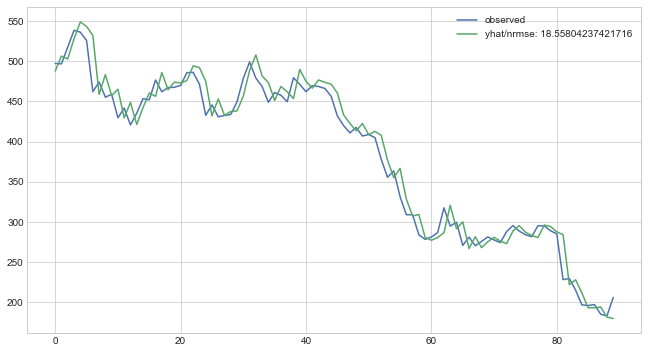

In [47]:
fig, ax = plt.subplots(figsize=(11,6))
plt.plot(observed, label="observed")
plt.plot(test_preds, label="yhat/nrmse: {}".format(test_rmse))
plt.legend()
plt.show()